# Project 3
## Task 3 - PennFudan

This is mostly a copy-and-paste job from the tutorial once again, but I organized the code differently to make for a cleaner notebook. I also show some output of my exploration of the dataset here. There is a lot going on behind the scenes, especially since the tutorial uses a lot of pre-written code from the `torchvision` Github repo, which I had to download (imported here from `detection`). It didn't quite work as advertised, so I had to do a bit of modification of the source code.

First, I download the tutorial data and looked at it using a mix of functions suggested by the tutorial and my own code:

In [1]:
import torch
import torchvision

import detection.utils as d_utils
import matplotlib.pyplot as plt

from task3_functions_pt2 import (PennFudanDataset, get_transform,
                                 get_model_instance_segmentation,
                                 train_and_evaluate)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

%matplotlib inline

In [2]:
explore_dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=False))
explore_data_loader = torch.utils.data.DataLoader(
 explore_dataset, batch_size=1, shuffle=True, num_workers=4,
 collate_fn=d_utils.collate_fn)

Image index: 68


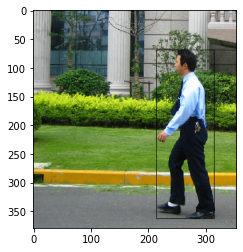

In [3]:
# Rerun this to look at various images and bounding-box targets
images,targets = next(iter(explore_data_loader))
im_uint8 = torchvision.transforms.functional.convert_image_dtype(images[0], dtype=torch.uint8)
im_box = torchvision.utils.draw_bounding_boxes(im_uint8, targets[0]['boxes'])
plt.imshow(torch.permute(im_box, (1,2,0)));
print(f'Image index: {int(targets[0]["image_id"])}')


Next I followed their tutorial to finetune a pretrained model:

In [4]:
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))
# grab torchvision.models.detection.maskrcnn_resnet50_fpn
# then modify the mask predictor to output only two classes
# foreground (i.e. person) vs background (i.e. not person)
model = get_model_instance_segmentation(num_classes=2)  

In [5]:
train_and_evaluate(dataset, dataset_test, model)

Epoch: [0]  [ 0/60]  eta: 0:04:19  lr: 0.000090  loss: 5.2017 (5.2017)  loss_classifier: 0.6096 (0.6096)  loss_box_reg: 0.3836 (0.3836)  loss_mask: 4.1916 (4.1916)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0145 (0.0145)  time: 4.3230  data: 1.8284  max mem: 2522
Epoch: [0]  [10/60]  eta: 0:00:37  lr: 0.000936  loss: 3.1199 (3.5915)  loss_classifier: 0.3728 (0.4059)  loss_box_reg: 0.1670 (0.2036)  loss_mask: 2.5907 (2.8866)  loss_objectness: 0.0363 (0.0774)  loss_rpn_box_reg: 0.0116 (0.0181)  time: 0.7574  data: 0.1676  max mem: 3870
Epoch: [0]  [20/60]  eta: 0:00:22  lr: 0.001783  loss: 1.1753 (2.9295)  loss_classifier: 0.1825 (0.2671)  loss_box_reg: 0.1383 (0.1819)  loss_mask: 0.7405 (1.8869)  loss_objectness: 0.0454 (0.2816)  loss_rpn_box_reg: 0.0131 (0.3121)  time: 0.3754  data: 0.0016  max mem: 3870
Epoch: [0]  [30/60]  eta: 0:00:14  lr: 0.002629  loss: 1.0173 (2.2889)  loss_classifier: 0.1046 (0.2163)  loss_box_reg: 0.1291 (0.1822)  loss_mask: 0.5878 (1.4664)  loss_ob

And now to test the model:

In [21]:
img, _ = dataset_test[10]
model.eval()
with torch.no_grad():
    prediction = model([img.to('cuda')])

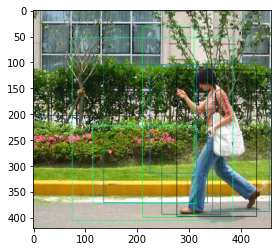

In [22]:
img_uint8 = torchvision.transforms.functional.convert_image_dtype(img, dtype=torch.uint8)
img_box = torchvision.utils.draw_bounding_boxes(img_uint8, prediction[0]['boxes'])
plt.imshow(torch.permute(img_box, (1,2,0)));

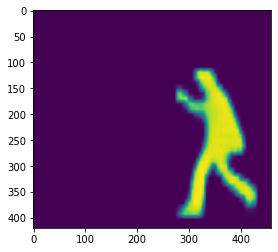

In [23]:
plt.imshow(prediction[0]['masks'][0, 0, ...].cpu())

## Appendix

### task3_functions_pt2.py

```python
import os
import numpy as np
import torch
import torchvision

import detection.transforms as T
import detection.utils as utils

from detection.engine import train_one_epoch, evaluate
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

    
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


def train_and_evaluate(dataset, dataset_test, model):
        # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

    
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
```